In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install livelossplot

## Les librairies


In [ ]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import to_categorical
from keras import regularizers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.applications.vgg16 import VGG16
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tqdm import tqdm

import livelossplot
from PIL import Image
import cv2
import numpy as np

import joblib


## Les fonctions


In [ ]:
## Prétraitement de l'image : redimensionnemennt et standardization
def preprocess_img(img,new_dim=(240,320)):
    new_img=cv2.resize(img, (new_dim[1],new_dim[0]), interpolation = cv2.INTER_AREA)
    # Normalisation en divisant par 255
    normalized_img = new_img / 255.0
    return normalized_img

## Récupération des images et préparation de la dataset

In [ ]:

# Chemin vers le dossier principal contenant les sous-dossiers
main_folder = '/content/drive/MyDrive/CAS_PRATIQUES /CAS_PRATIQUES/MMU-Iris-Database'
img_dim=(240,320,3)


In [ ]:
X_left, X_right, X_r_or_l = [], [], []
Y_left, Y_right, Y_r_or_l = [], [], []


for target_folder in os.listdir(main_folder):
    target_path = os.path.join(main_folder, target_folder)

    if os.path.isdir(target_path):
        for side in ['left', 'right']:  # Utilize the simplified loop for both 'left' and 'right'
            side_path = os.path.join(target_path, side)

            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        target = int(target_folder)
                        image_save = preprocess_img(cv2.imread(image_path), img_dim)
                        X_side = X_left if side == 'left' else X_right
                        Y_side = Y_left if side == 'left' else Y_right
                        X_side.append(image_save)
                        Y_side.append(target)
                        X_r_or_l.append(image_save)
                        Y_r_or_l.append(1 if side == 'left' else 0)


In [ ]:
print(len(X_left),len(Y_left))
print(len(X_right),len(Y_right))
print(len(X_r_or_l),len(Y_r_or_l))

225 225
225 225
450 450


---
---
## Entrainement du modèle et affichage des performances

In [ ]:
# Arrêt anticipé et Réductionde de descente de gradient
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
early = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)

In [ ]:
NBCLASSES = 45
IMSIZE=[240,320]


def create_model():
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Freeze existing VGG already trained weights

    for layer in vgg.layers:
        layer.trainable = False

    # get the VGG output
    out = vgg.output

    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=x)

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    model.summary()

    return model


In [ ]:
# Création d'une fonction d'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=(0.8,1.2)
)


def data_aug(data_x,data_y,multiplicateur):
  aug_x=[]
  aug_y=[]

  for i in range(len(data_x)):
    x = image.img_to_array(data_x[i])
    x = x * 255
    x = np.expand_dims(x, axis=0)
    count=0
    for batch in datagen.flow(x, batch_size=1):
      aug_x.append(batch[0]/255)
      aug_y.append(data_y[i])
      count+=1
      if count>=multiplicateur:
        break

  return aug_x,aug_y



---
## OEIL GAUCHE

In [ ]:
labelEnc_left=preprocessing.LabelEncoder()
Y_enc_left=labelEnc_left.fit_transform(Y_left)

joblib.dump(labelEnc_left,'/content/drive/MyDrive/CAS_PRATIQUES /CAS_PRATIQUES/code/joblib/encodeur_OG.joblib')

['/content/drive/MyDrive/CAS_PRATIQUES /CAS_PRATIQUES/code/joblib/encodeur_OG.joblib']

#### Split et sauvegarde de 2 images du groupe test

In [ ]:
# Split the data into training and testing sets while maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X_left, Y_enc_left, test_size=0.2, random_state=42, stratify=Y_enc_left)

for i in range(-3,-1):
  output_path = f'/content/drive/MyDrive/CAS_PRATIQUES /CAS_PRATIQUES/save_pour_appli/id_{labelEnc_left.inverse_transform(y_test)[i]}_OG.bmp'
  last_preprocessed_img = X_test[i]
  im = Image.fromarray((last_preprocessed_img * 255).astype(np.uint8))
  im.save(output_path)



In [ ]:
multiplicateur_aug_train = 5
multiplicateur_aug_test = 2

aug_X_train,aug_y_train = data_aug(X_train,y_train,multiplicateur_aug_train)
aug_X_test,aug_y_test = data_aug(X_train,y_train,multiplicateur_aug_test)

#### Visualisation des transformations sur la première image

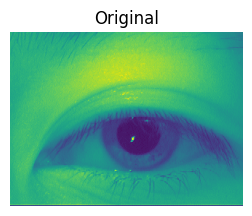

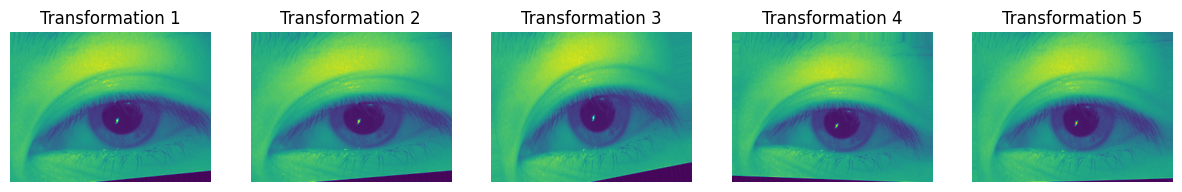

In [ ]:
# image origine
plt.figure(figsize=(3,5))
plt.imshow(X_train[0][:,:,2])
plt.title(f'Original')
plt.axis('off')
plt.show()

# Images transformées
plt.figure(figsize=(15, 5))
for i in range(multiplicateur_aug_train):
    plt.subplot(1, multiplicateur_aug_train, i + 1)
    plt.imshow(aug_X_train[i][:,:,2])
    plt.title(f'Transformation {i+1}')
    plt.axis('off')
plt.show()


In [ ]:
for i in range(len(aug_X_train)):
  X_train.append(aug_X_train[i])
  y_train = np.concatenate((y_train, np.array([aug_y_train[i]])))

for i in range(len(aug_X_test)):
  X_test.append(aug_X_test[i])
  y_test = np.concatenate((y_test, np.array([aug_y_test[i]])))


In [ ]:
y_train_enc=to_categorical(y_train)
y_test_enc=to_categorical(y_test)



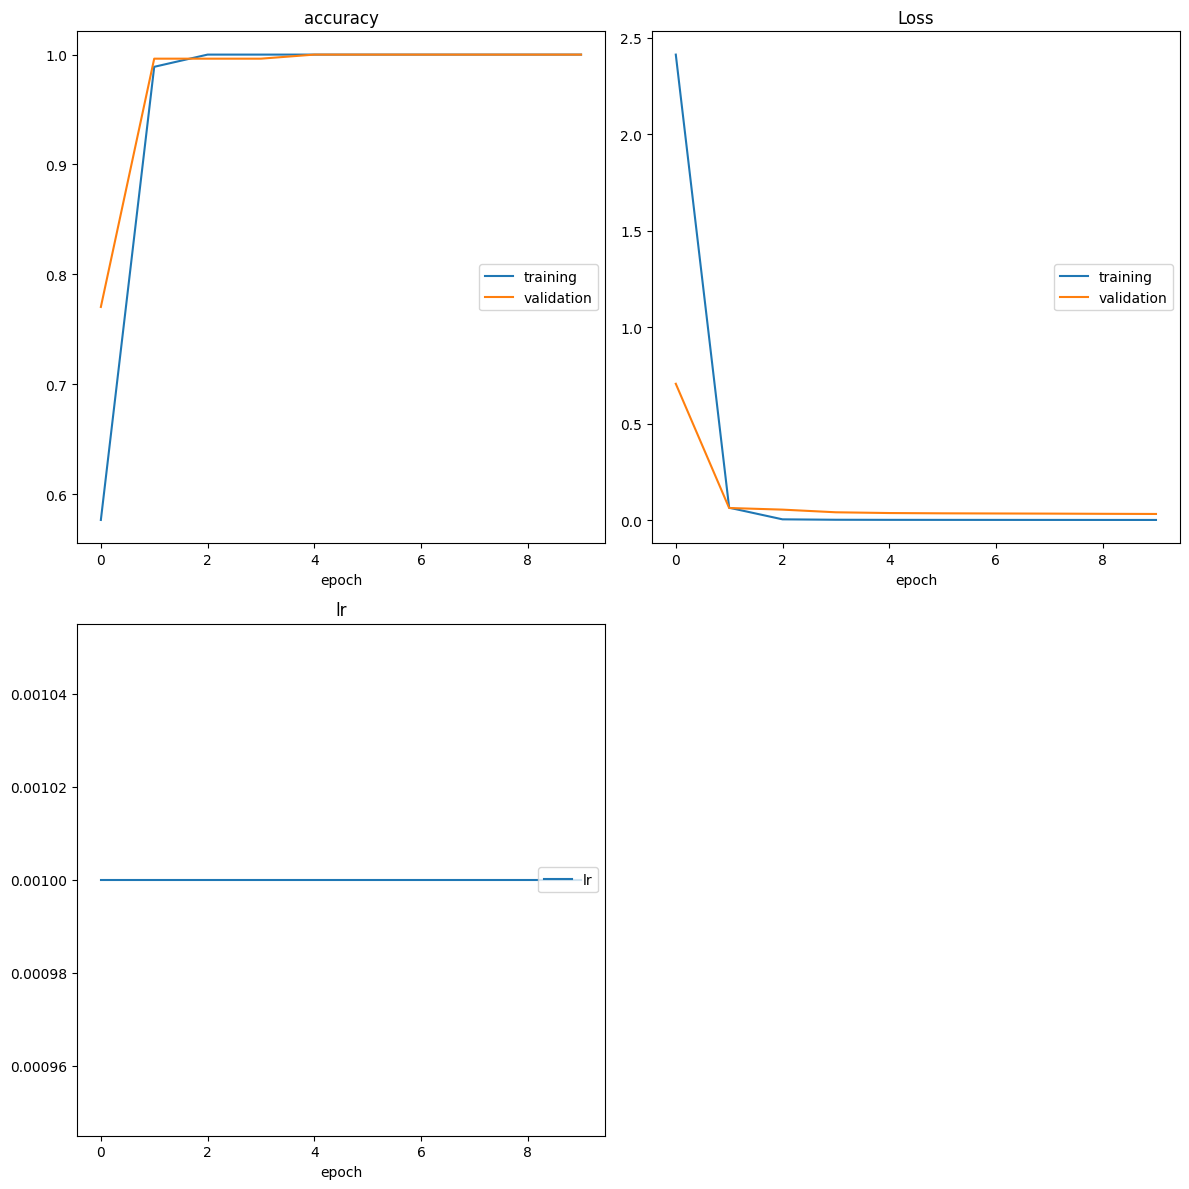

accuracy
	training         	 (min:    0.577, max:    1.000, cur:    1.000)
	validation       	 (min:    0.770, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.001, max:    2.413, cur:    0.001)
	validation       	 (min:    0.032, max:    0.707, cur:    0.032)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
27/27 [==============================] - 8s 305ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0322 - val_accuracy: 1.0000 - lr: 0.0010


In [ ]:
OG_model = create_model()
hist = OG_model.fit(np.array(X_train), np.array(y_train_enc), batch_size = 30, epochs = 10, validation_split=0.25,callbacks=[rlrop,early,PlotLossesKeras()])

In [ ]:
y_test_pred = [np.argmax(v) for v in OG_model.predict(np.array(X_test))]  # Prédictions du modèle


13/13 [==============================] - 3s 193ms/step


In [ ]:
def matrice(y_test,y_test_pred,titre):
  # Calcul de la matrice de confusion
  conf_matrix = confusion_matrix(np.array(y_test), np.array(y_test_pred))

  # Calcul des mesures de performance
  accuracy = accuracy_score(y_test, y_test_pred)
  precision = precision_score(y_test, y_test_pred,average='macro')
  recall = recall_score(y_test, y_test_pred,average='macro')
  f1 = f1_score(y_test, y_test_pred,average='macro')


  print("Matrice de confusion Oeil gauche:")
  print("Précision : {:.2f}".format(precision))
  print("Rappel : {:.2f}".format(recall))
  print("Score F1 : {:.2f}".format(f1))
  print("Exactitude : {:.2f}".format(accuracy))

  plt.figure(figsize=(15, 10))
  # sns.set(font_scale=1.2)  # Échelle de la police pour une meilleure lisibilité

  # Utilisez Seaborn pour rendre la matrice de confusion plus esthétique
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")

  # Ajoutez des étiquettes et un titre
  plt.xlabel("Classe Prédite")
  plt.ylabel("Vraie Classe")
  plt.title(titre)

  # Affichez la matrice de confusion
  plt.show()



Matrice de confusion Oeil gauche:
Précision : 1.00
Rappel : 1.00
Score F1 : 1.00
Exactitude : 1.00


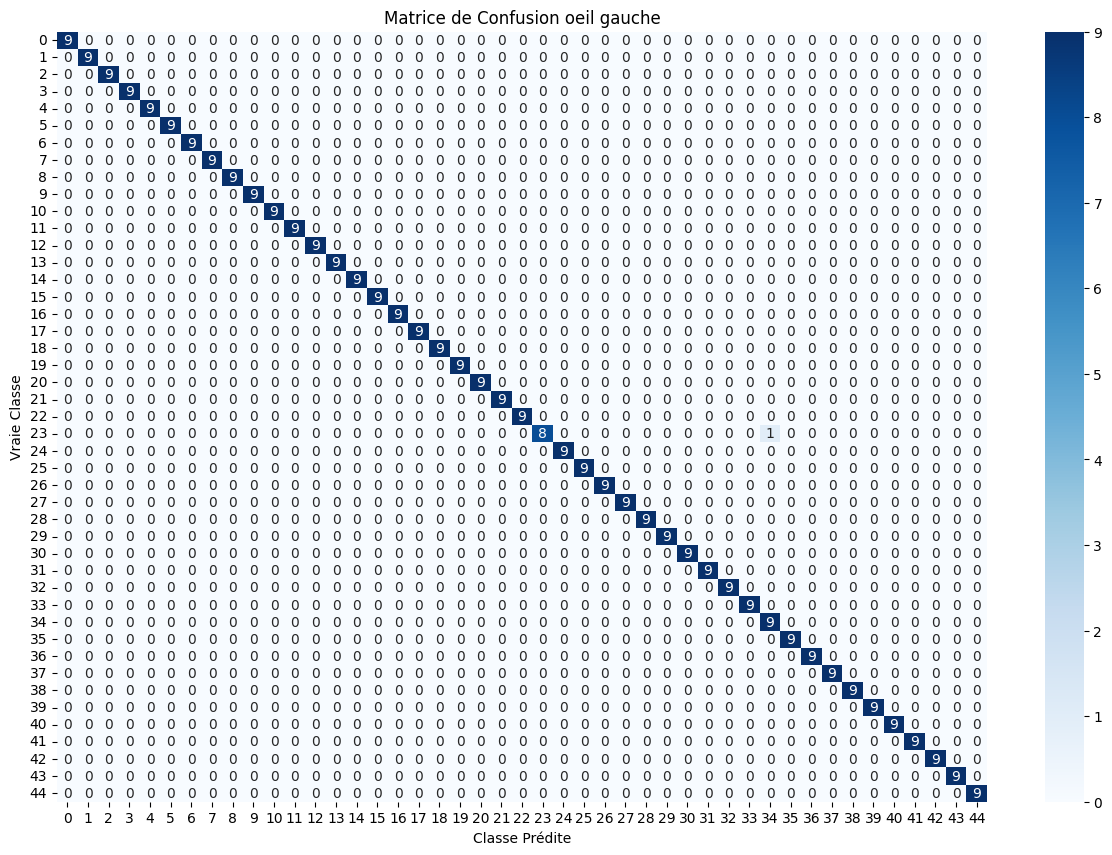

In [ ]:
matrice(y_test,y_test_pred,"Matrice de Confusion oeil gauche")

In [ ]:
OG_model.save("/content/drive/MyDrive/CAS_PRATIQUES /CAS_PRATIQUES/OG_classif")

---
## OEIL DROIT

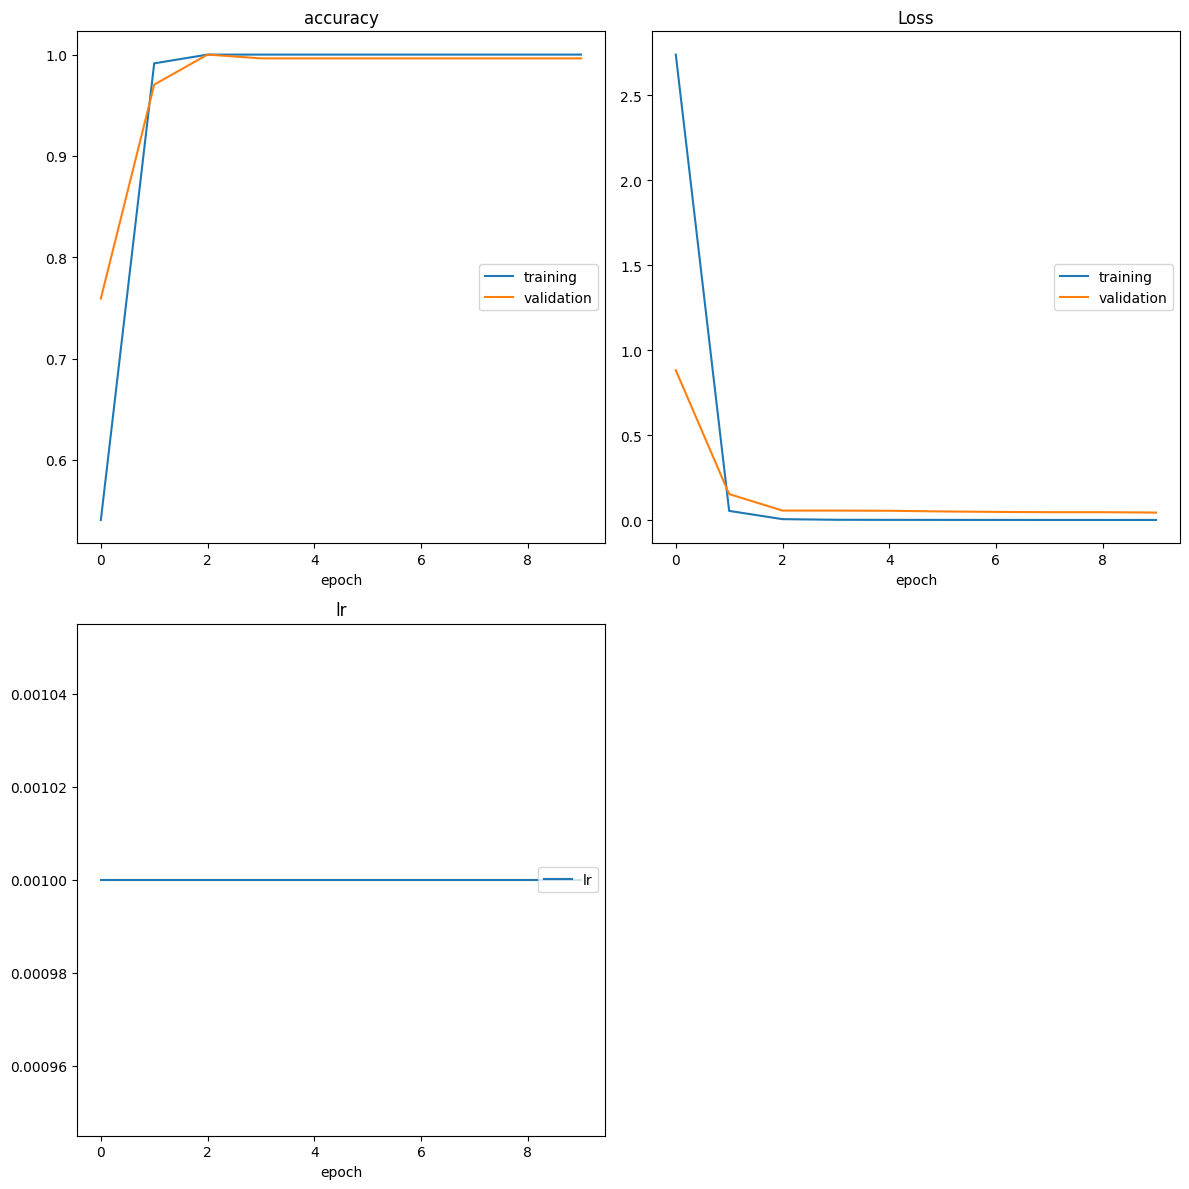

accuracy
	training         	 (min:    0.541, max:    1.000, cur:    1.000)
	validation       	 (min:    0.759, max:    1.000, cur:    0.996)
Loss
	training         	 (min:    0.001, max:    2.739, cur:    0.001)
	validation       	 (min:    0.045, max:    0.882, cur:    0.045)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
27/27 [==============================] - 8s 284ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0445 - val_accuracy: 0.9963 - lr: 0.0010


In [ ]:
labelEnc_yr=preprocessing.LabelEncoder()
Y_enc_yr=labelEnc_yr.fit_transform(Y_left)

joblib.dump(labelEnc_yr,'/content/drive/MyDrive/CAS_PRATIQUES /CAS_PRATIQUES/code/joblib/encodeur_OD.joblib')

X_train, X_test, y_train, y_test = train_test_split(X_right, Y_enc_yr, test_size=0.2, random_state=42, stratify=Y_enc_yr)

for i in range(-3,-1):
  output_path = f'/content/drive/MyDrive/CAS_PRATIQUES /CAS_PRATIQUES/save_pour_appli/id_{labelEnc_yr.inverse_transform(y_test)[i]}_OD.bmp'
  last_preprocessed_img = X_test[i]
  im = Image.fromarray((last_preprocessed_img * 255).astype(np.uint8))
  im.save(output_path)

aug_X_train,aug_y_train = data_aug(X_train,y_train,5)
aug_X_test,aug_y_test = data_aug(X_train,y_train,2)

for i in range(len(aug_X_train)):
  X_train.append(aug_X_train[i])
  y_train = np.concatenate((y_train, np.array([aug_y_train[i]])))

for i in range(len(aug_X_test)):
  X_test.append(aug_X_test[i])
  y_test = np.concatenate((y_test, np.array([aug_y_test[i]])))

y_train_enc=to_categorical(y_train)
y_test_enc=to_categorical(y_test)

OD_model = create_model()

hist = OD_model.fit(np.array(X_train), np.array(y_train_enc), batch_size = 30, epochs = 10, validation_split=0.25,callbacks=[rlrop,early,PlotLossesKeras()])

13/13 [==============================] - 2s 193ms/step
Matrice de confusion Oeil gauche:
Précision : 0.99
Rappel : 0.99
Score F1 : 0.99
Exactitude : 0.99


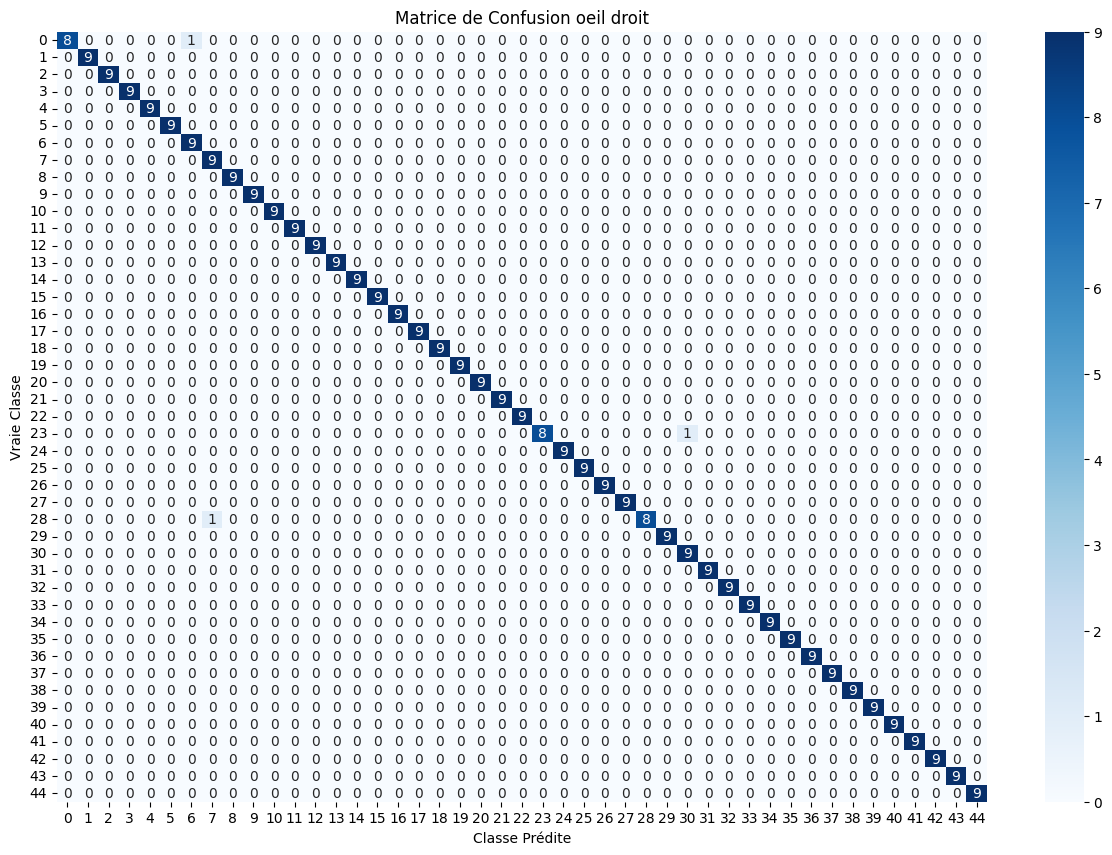

In [ ]:
y_test_pred = [np.argmax(v) for v in OD_model.predict(np.array(X_test))]  # Prédictions du modèle
matrice(y_test,y_test_pred,"Matrice de Confusion oeil droit")

In [ ]:
OD_model.save("/content/drive/MyDrive/CAS_PRATIQUES /CAS_PRATIQUES/OD_classif")

---
## OEIL GAUCHE OU DROIT ?

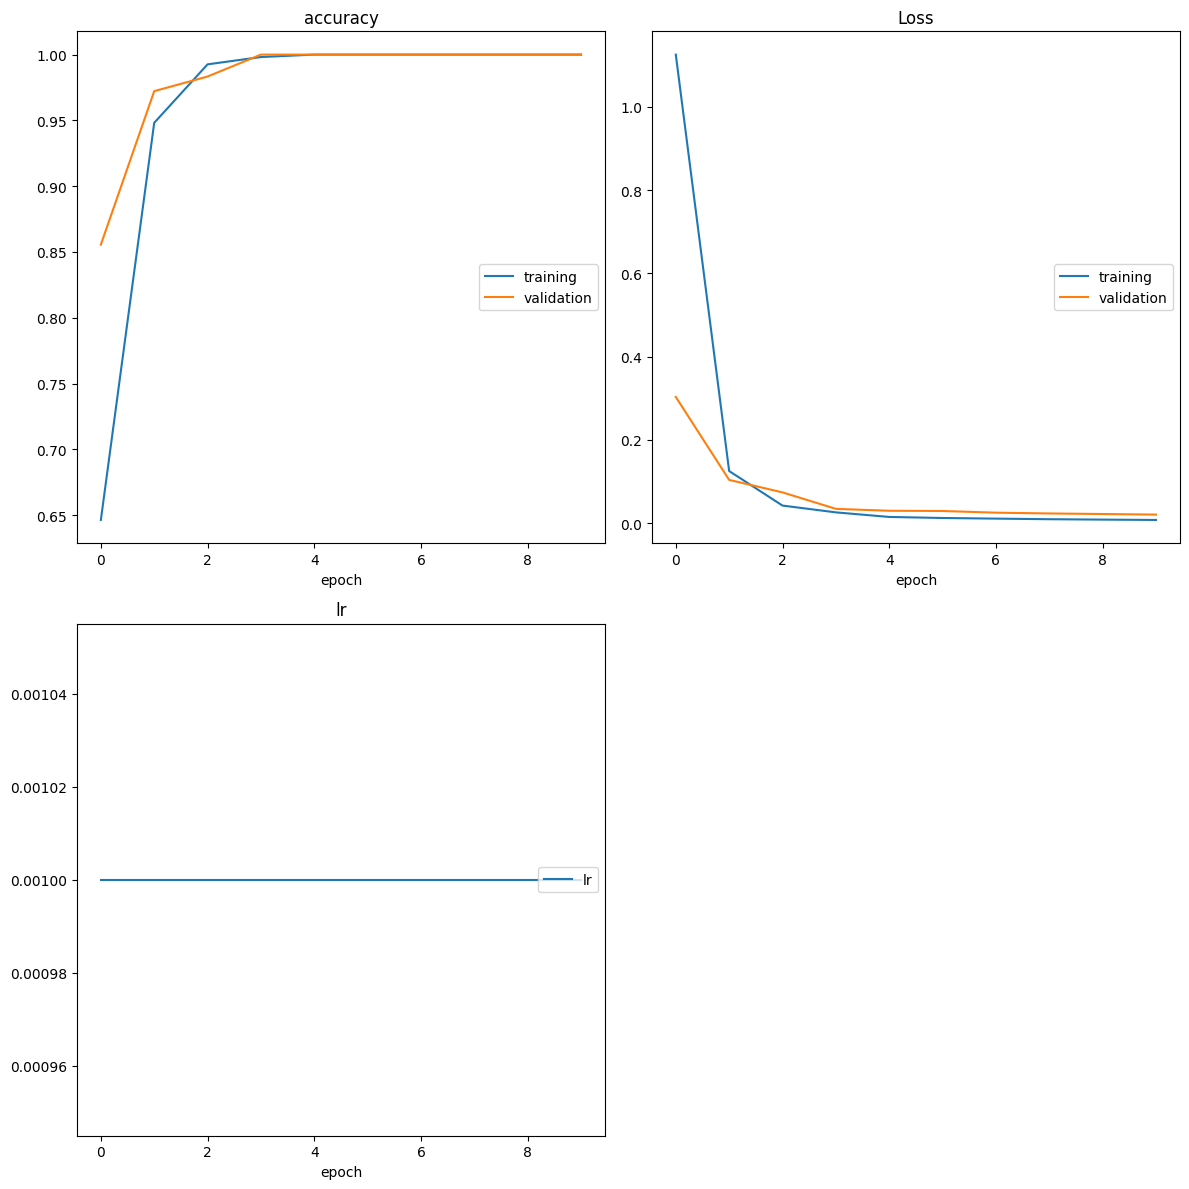

accuracy
	training         	 (min:    0.646, max:    1.000, cur:    1.000)
	validation       	 (min:    0.856, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.008, max:    1.125, cur:    0.008)
	validation       	 (min:    0.020, max:    0.303, cur:    0.020)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
18/18 [==============================] - 5s 296ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000 - lr: 0.0010


In [ ]:
labelEnc_ylr=preprocessing.LabelEncoder()
Y_enc_ylr=labelEnc_ylr.fit_transform(Y_r_or_l)

joblib.dump(labelEnc_ylr,'/content/drive/MyDrive/CAS_PRATIQUES /CAS_PRATIQUES/code/joblib/encodeur_ODG.joblib')


X_train, X_test, y_train, y_test = train_test_split(X_r_or_l, Y_enc_ylr, test_size=0.2, random_state=42, stratify=Y_enc_ylr)

aug_X_train,aug_y_train = data_aug(X_train,y_train,1)
aug_X_test,aug_y_test = data_aug(X_train,y_train,1)

for i in range(len(aug_X_train)):
  X_train.append(aug_X_train[i])
  y_train = np.concatenate((y_train, np.array([aug_y_train[i]])))

for i in range(len(aug_X_test)):
  X_test.append(aug_X_test[i])
  y_test = np.concatenate((y_test, np.array([aug_y_test[i]])))

y_train_enc=to_categorical(y_train)
y_test_enc=to_categorical(y_test)

NBCLASSES=2
OGD_model = create_model()

hist = OGD_model.fit(np.array(X_train), np.array(y_train_enc), batch_size = 30, epochs = 10, validation_split=0.25,callbacks=[rlrop,early,PlotLossesKeras()])

15/15 [==============================] - 3s 187ms/step
Matrice de confusion Oeil gauche:
Précision : 1.00
Rappel : 1.00
Score F1 : 1.00
Exactitude : 1.00


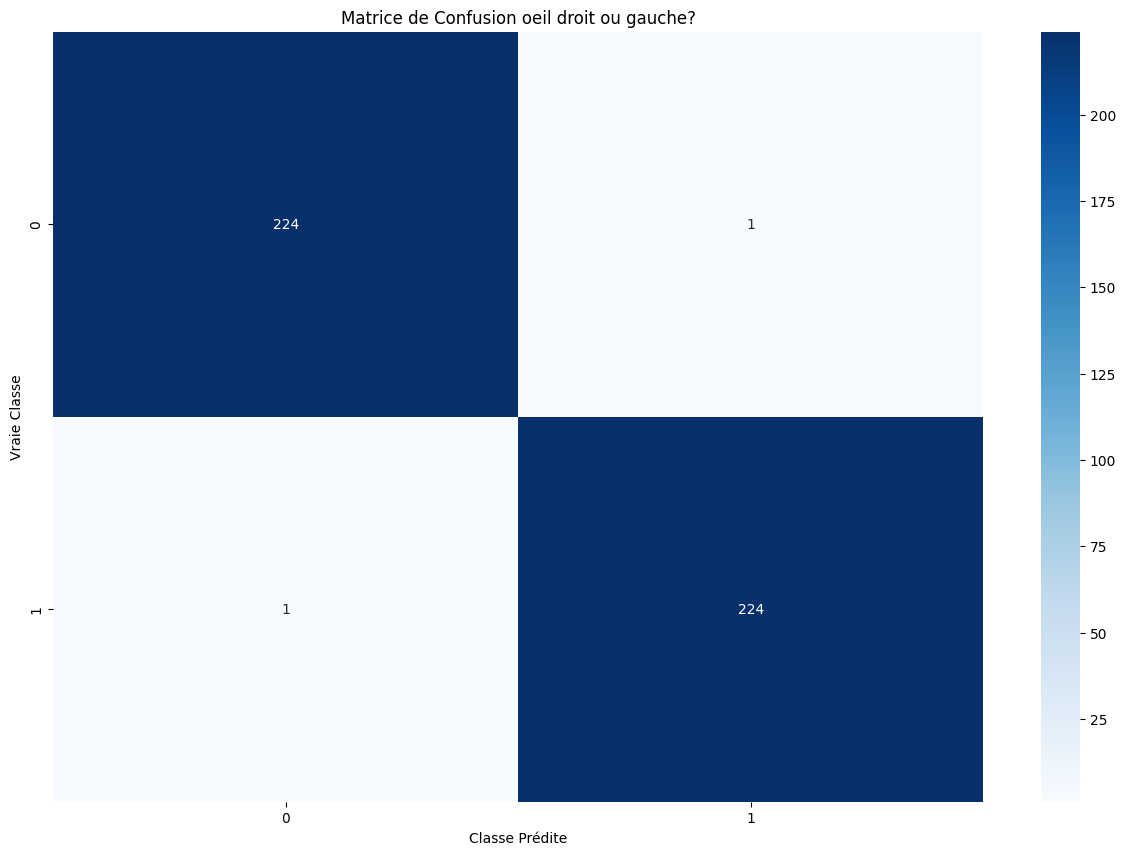

In [ ]:
y_test_pred = [np.argmax(v) for v in OGD_model.predict(np.array(X_test))]  # Prédictions du modèle
matrice(y_test,y_test_pred,"Matrice de Confusion oeil droit ou gauche?")

In [ ]:
OGD_model.save("/content/drive/MyDrive/CAS_PRATIQUES /CAS_PRATIQUES/ODG_classif")